# MushCamp EfficientNetB7

### Import Library

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from efficientnet.tfkeras import EfficientNetB7

### Load Data

In [2]:
trainPath = r'dataset\dataSplit\train'
validationPath = r'dataset\dataSplit\val'
testPath = r'dataset\dataSplit\test'

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Data Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.45,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

#Train
train_generator = train_datagen.flow_from_directory(
                                            trainPath,
                                                    target_size=(300, 300),
                                                    batch_size=64,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                            )

#Validation
validation_generator=val_datagen.flow_from_directory(
                                            validationPath,
                                                    target_size=(300,300),
                                                    batch_size=64,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                )

#Test
test_generator=val_datagen.flow_from_directory(
                                            testPath,
                                                    target_size=(300,300),
                                                    batch_size=64,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                )

Found 2232 images belonging to 9 classes.
Found 279 images belonging to 9 classes.
Found 288 images belonging to 9 classes.


##### CallBacks

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.4, patience=3, 
                                    verbose=1, mode='min', 
                                    min_delta=0.0001, min_lr=0,
                                    restore_best_weights=True)

##### Load Model EfficientNetB7

In [6]:
pre_trained_model_B7 = EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=(300, 300, 3),
    pooling='avg',
)

##### Layering EfficientNetB7

In [7]:
for layer in pre_trained_model_B7.layers:
    layer.trainable = False


last_layer = pre_trained_model_B7.get_layer('avg_pool')
last_output = last_layer.output


x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense (9, activation='softmax')(x)

model_B7 = Model( pre_trained_model_B7.input, x) 

model_B7.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

##### Training Model with EfficeintNetB7

In [9]:
history = model_B7.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 50,
            callbacks=[reduceLROnPlat],
            verbose = 1)  

Epoch 1/50
35/35 [==============================] - 54s 2s/step - loss: 1.5717 - accuracy: 0.4310 - val_loss: 1.0679 - val_accuracy: 0.6022 - lr: 0.0010
Epoch 2/50
35/35 [==============================] - 46s 1s/step - loss: 1.2200 - accuracy: 0.5600 - val_loss: 0.8131 - val_accuracy: 0.7204 - lr: 0.0010
Epoch 3/50
35/35 [==============================] - 48s 1s/step - loss: 1.0326 - accuracy: 0.6398 - val_loss: 0.6859 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 4/50
35/35 [==============================] - 50s 1s/step - loss: 0.9989 - accuracy: 0.6483 - val_loss: 0.6110 - val_accuracy: 0.8136 - lr: 0.0010
Epoch 5/50
35/35 [==============================] - 51s 1s/step - loss: 0.8369 - accuracy: 0.7007 - val_loss: 0.5790 - val_accuracy: 0.8065 - lr: 0.0010
Epoch 6/50
35/35 [==============================] - 53s 1s/step - loss: 0.8457 - accuracy: 0.7137 - val_loss: 0.5705 - val_accuracy: 0.8172 - lr: 0.0010
Epoch 7/50
35/35 [==============================] - 51s 1s/step - loss: 0.7683 - a

##### Eval Model using Data Testing

In [11]:
B7_eval = model_B7.evaluate(test_generator,verbose=0)
B7_acc = round(B7_eval[1],2) * 100
B7_acc

82.0

##### Save Model

In [ ]:
model_B7.save('saved-models/model_EfficientNetB7.h5')

##### Confusion Matrix

In [14]:
import os

class_names = os.listdir(trainPath)
print('All category : ',class_names)

All category :  ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


In [15]:
y_test = []
y_pred = []

for i in range(len(test_generator)) :
    x,y = test_generator.next()
    for j in range(len(y)) :
        y_test.append(class_names[tf.argmax(y[j])])
        y_pred.append(class_names[np.argmax(model_B7.predict(x[j][None,...],verbose=0))])

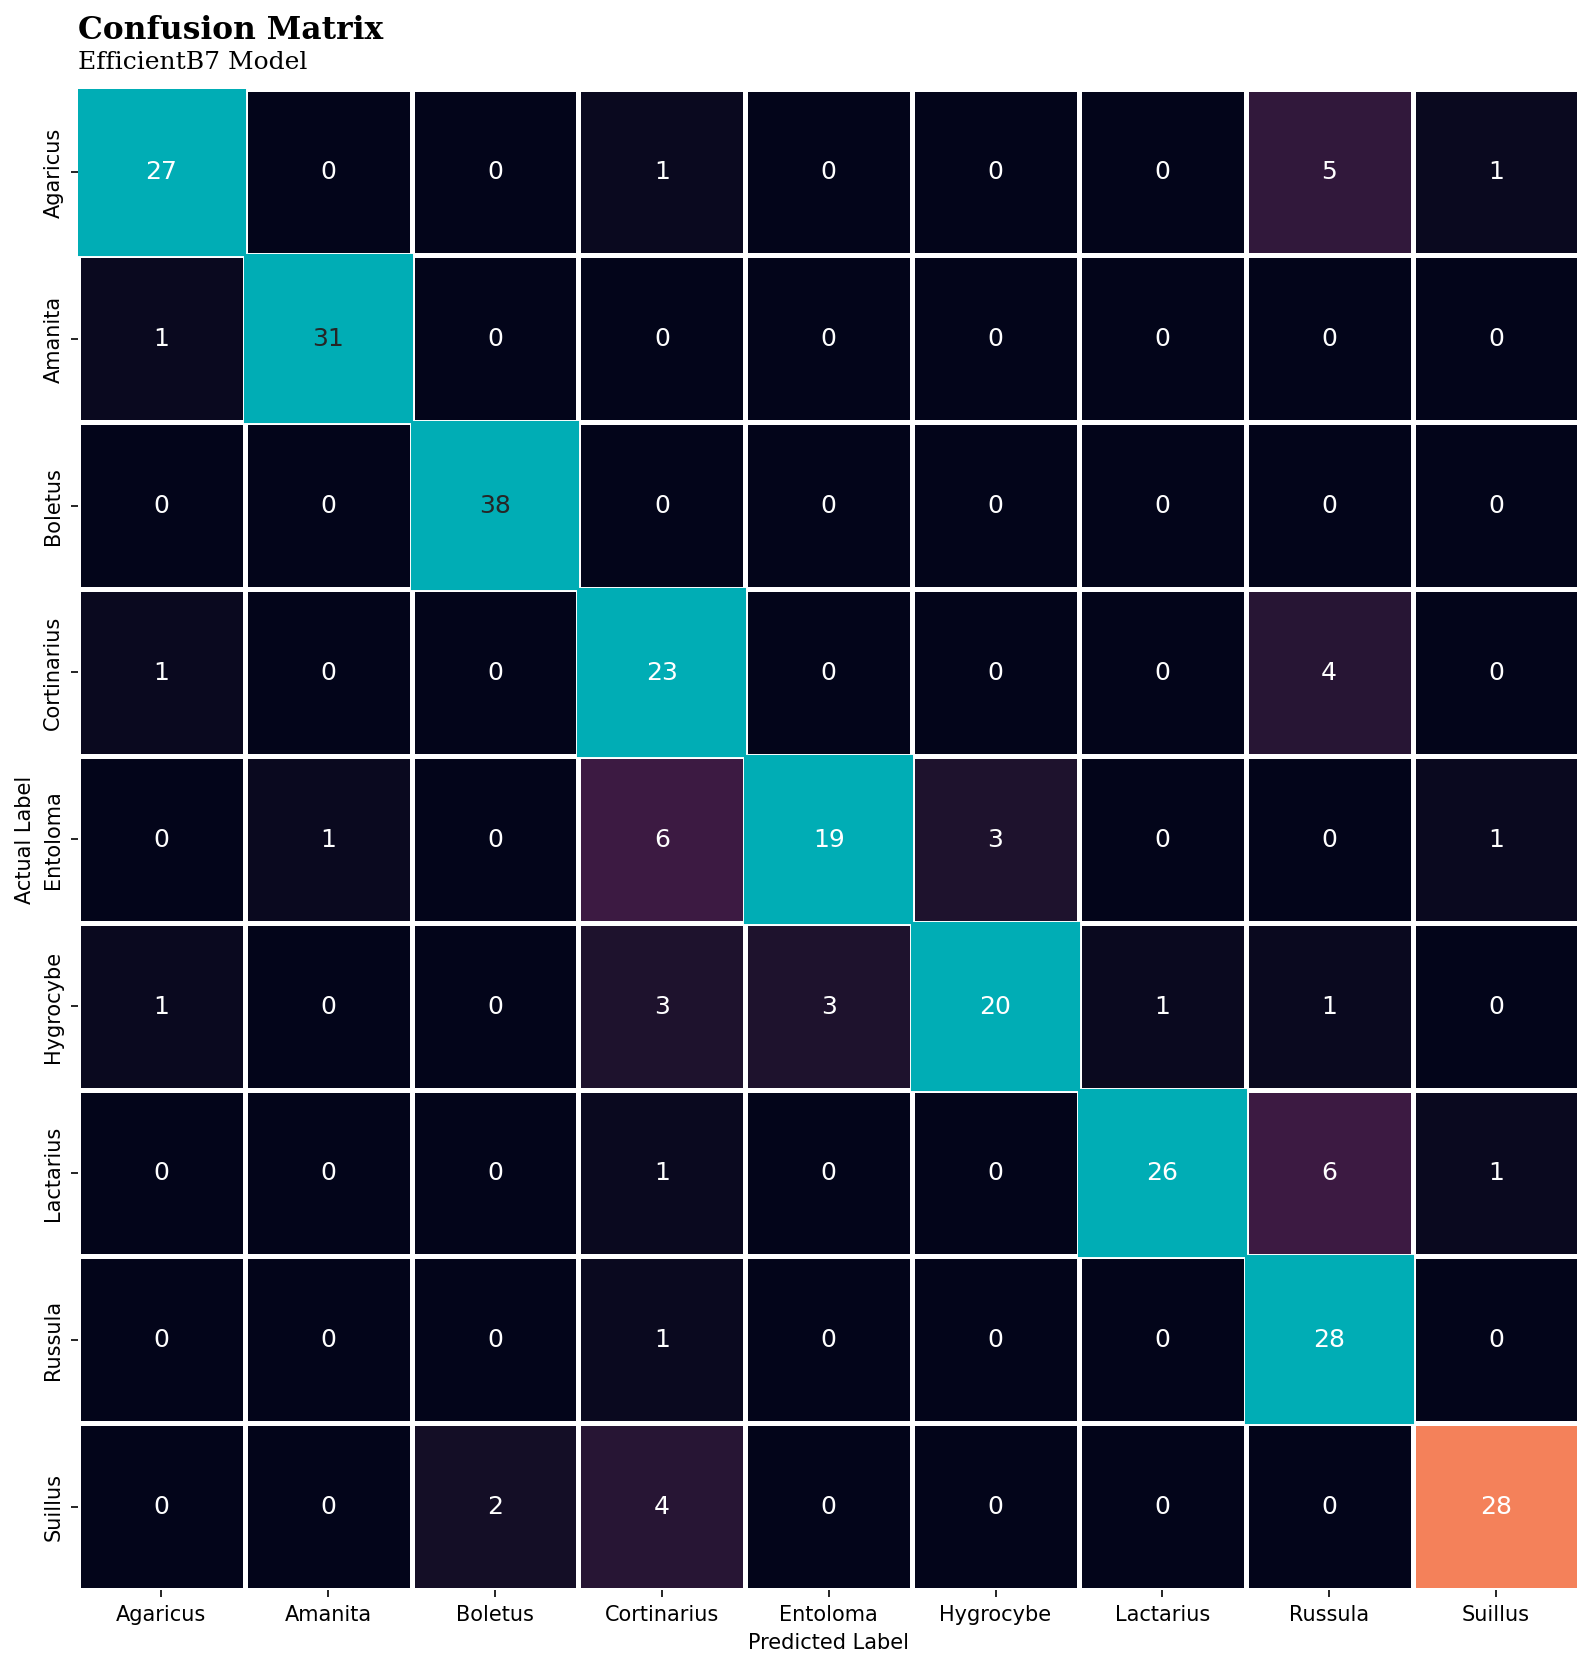

In [17]:
fig, ax = plt.subplots(figsize=(18, 13),dpi=150)
cm = confusion_matrix(y_test, y_pred)

colors = ["#393E46","#393E46"]

ax.text(0,-0.3,'Confusion Matrix ',fontfamily='serif',fontsize=15,fontweight='bold')
ax.text(0,-0.12,'EfficientB7 Model',fontfamily='serif',fontsize=12,fontweight='light')
sns.heatmap(ax=ax, data=cm,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=1.5, annot=True, 
            annot_kws={"fontsize":12},fmt='')

ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

ax.set_ylabel("Actual Label",fontsize=10)
ax.set_xlabel("Predicted Label",fontsize=10)

from matplotlib.patches import Rectangle
for i in range(0,8):
    ax.add_patch(Rectangle((i, i), 1, 1, fill=True,color='#00ADB5'))

plt.show()